In [1]:
!pip install git+https://github.com/LAL/trackml-library.git

  Cloning https://github.com/LAL/trackml-library.git to /tmp/pip-req-build-rjn27imq
  Running command git clone -q https://github.com/LAL/trackml-library.git /tmp/pip-req-build-rjn27imq
  Created wheel for trackml: filename=trackml-3-py2.py3-none-any.whl size=13512 sha256=30114c07f0eb394e343eee68719e39a96e1fa5e1c315334d0a9ea2ca11fc5258
  Stored in directory: /tmp/pip-ephem-wheel-cache-998qu863/wheels/0f/9a/5f/be8818e35f0d18b449158a62387337b237826b5cc21a1b28eb
Successfully built trackml


In [2]:
# Clonning the repository
!git clone https://github.com/stonescenter/track-particles.git cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 101 (delta 45), reused 98 (delta 42), pack-reused 0
Receiving objects: 100% (101/101), 11.74 MiB | 12.61 MiB/s, done.
Resolving deltas: 100% (45/45), done.
cloned-repo  sample_data


In [3]:
%cd cloned-repo/

/content/cloned-repo


# Run with NoteBooks #

In [7]:
import sys
import os
import json

from core.data.data_loader import *
from core.models.lstm import ModelLSTM, ModelLSTMParalel
from core.data.data_loader import FeatureType, Dataset


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import set_random_seed

import keras.backend as K
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


## loading Configurartion ##


In [8]:
# load some configurations configurations of model and others

configs = json.load(open('config-paralel.json', 'r'))
save_dir = configs['paths']['save_dir']
save_fname = os.path.join(save_dir, 'architecture-%s.png' % configs['model']['name'])
save_fnameh5 = os.path.join(save_dir, 'model-%s.h5' % configs['model']['name'])
print(save_fname) 
print(save_fnameh5)
print('OK reading of json file')

results/architecture-lstm-paralel.png
results/model-lstm-paralel.h5
OK reading of json file


## Setup Data ##

In [9]:
# reading path of data
#path = './dataset/phi025-025_eta025-025/phi025-025_eta025-025_filtered.csv'
path = configs['data']['filename']
path

'./dataset/phi025-025_eta025-025_filtered.csv'

In [10]:
# reading particle positions
data = Dataset(path, KindNormalization.Zscore)

X, X_, y = data.prepare_training_data(FeatureType.Divided, normalise=True,
                                                  cilyndrical=False)
#X, y = data.prepare_training_data(FeatureType.Positions, normalise=False,
#                                                  cilyndrical=False)

X.head()

[Data] data loaded from  ./dataset/phi025-025_eta025-025_filtered.csv
[Data] shape datas X:  (15192, 16)
[Data] shape data y:  (15192, 3)
[Data] len data total: 15192


,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3
0,-0.197514,0.447192,0.215793,-0.207645,0.504261,0.094703,-0.209314,0.480264,0.034145,-0.223646,0.405745,-0.000333
1,-0.225104,0.905615,0.454577,-0.241666,1.113409,0.434772,-0.235227,1.182940,0.395443,-0.259084,1.195713,0.362829
2,-0.219544,-0.252188,0.829579,-0.215628,-0.310552,0.963034,-0.215073,-0.304692,0.962387,-0.224862,-0.266718,0.952794
3,3.086830,5.527004,1.322880,3.267902,4.838781,1.578658,3.266429,4.533334,1.620158,3.406857,4.364378,1.654012
4,-0.195694,0.416933,0.610438,-0.207160,0.495587,0.689542,-0.218343,0.513846,0.680414,-0.234667,0.513960,0.667967


In [11]:
#reading particle values
X_.head()

,value_0,value_1,value_2,value_3
0,-0.196225,-0.272555,-0.245471,-0.295344
1,-0.212564,-0.248243,-0.182892,-0.201048
2,-0.114694,-0.199678,-0.186903,-0.249061
3,-0.096597,2.961432,2.356338,1.588075
4,-0.185638,-0.188648,-0.058163,-0.256392


In [12]:
# there is empty data?
X.isnull().values.any()
X.isna().sum()

x_0    0
y_0    0
z_0    0
x_1    0
y_1    0
z_1    0
x_2    0
y_2    0
z_2    0
x_3    0
y_3    0
z_3    0
dtype: int64

In [13]:
# reshape data     
time_steps =  configs['model']['layers'][0]['input_timesteps']  # the number of points or hits
num_features = configs['model']['layers'][0]['input_features']  # the number of features of each hits

X = data.reshape3d(X, time_steps, num_features)
X_ = data.reshape3d(X_, time_steps, 1)

# always the same info 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, X_train_, X_test_, y_train, y_test = train_test_split(X, X_, y,
                                                                    test_size=1-0.8, random_state=42)

print('[Data] shape X_train ', X_train.shape)
print('[Data] shape X_test ', X_test.shape)
print('[Data] shape y_train ', y_train.shape)
print('[Data] shape y_test ', y_test.shape)



[Data] shape X_train  (12153, 4, 3)
[Data] shape X_test  (3039, 4, 3)
[Data] shape y_train  (12153, 3)
[Data] shape y_test  (3039, 3)


## Create Model ##

In [15]:
# geramos o modelo
model = ModelLSTMParalel(configs)

model.build_model()
  




[Model] Creating model..



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

[Model] Model Compiled with structure: [<tf.Tensor 'input_1:0' shape=(?, 4, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 4, 1) dtype=float32>]
Time taken: 0:00:00.888082


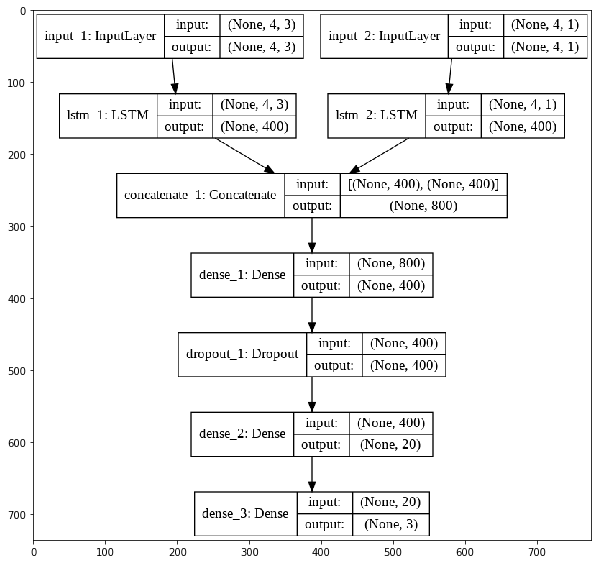

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

fig = plt.figure(figsize=(10, 14))
img=mpimg.imread('results/architecture-lstm-paralel.png')
imgplot = plt.imshow(img)
plt.show()


## Training Model ##

In [17]:
# in-memory training
x_train = [X_train, X_train_]
history = model.train(
    x=x_train,
    y=y_train,
    epochs = configs['training']['epochs'],
    batch_size = configs['training']['batch_size']

)

[Model] Training Started
[Model] 20 epochs, 128 batch size
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8142 samples, validate on 4011 samples
Epoch 1/20




8142/8142 [==============================] - 4s 432us/step - loss: 0.1105 - acc: 0.8725 - val_loss: 0.0350 - val_acc: 0.9120
Epoch 2/20
8142/8142 [==============================] - 1s 179us/step - loss: 0.0419 - acc: 0.9102 - val_loss: 0.0317 - val_acc: 0.9362
Epoch 3/20
8142/8142 [==============================] - 2s 192us/step - loss: 0.0315 - acc: 0.9300 - val_loss: 0.0320 - val_acc: 0.9526
Epoch 4/20
8142/8142 [==============================] - 1s 171us/step - loss: 0.0239 - acc: 0.9440 - val_loss: 0.0168 - val_acc: 0.9708
Epoch 5/20
8142/8142 [==============================] - 1s 170us/step - loss: 0.0195 - acc: 0.9512 - val_loss: 0.0191 - val_acc: 0.9638
Epoch 6/20
8142/8142 [==============================] - 1s 172us/step - loss: 0.0181 - acc: 0.9535 - val_loss: 0.

## Evaluate The model ##


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
[Ouput] Validation accuracy: 0.964348042763192, loss: 0.023200873438952937


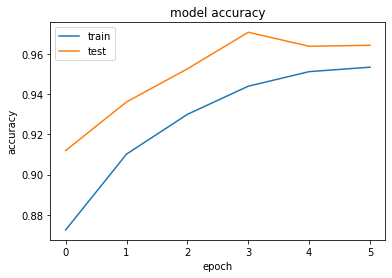

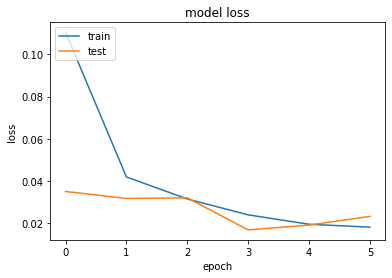

[Output] resulta saved at %s results/eval-loss.png


In [18]:
#evaluate the model
from core.utils.metrics import *
evaluate_training(history,save_dir)

## Prediction ##
We concatenate features to predict one hit.

In [19]:
# Prediction
import numpy as np
from core.utils.metrics import *
from core.utils.utils import *

x_test = [X_test, X_test_]

predicted = model.predict_one_hit(x_test)


[Model] Predicting Point-by-Point...
[Model] Shape predict result (3039, 3) size 9117


In [20]:
# Convert to original data
#y_predicted = data.reshape2d(predicted, 1)
   
y_predicted = np.reshape(predicted, (predicted.shape[0]*predicted.shape[1], 1))
y_true_ = data.reshape2d(y_test, 1)

result = calc_score(y_true_, y_predicted, report=True)
r2, rmse, rmses = evaluate_forecast(y_test.values, predicted)
summarize_scores(r2, rmse,rmses)


[Output] ---Regression Scores--- 
	R_2 statistics        (R2)  = 0.979
	Root Mean Square Error(RMSE) = 0.143
	Mean Absolute Error   (MAE) = 0.06

RMSE:		[0.143] 
RMSE features: 	[0.21, 0.10, 0.08] 
R^2  features:	[0.95, 0.99, 0.99] 


## Calculate Distances( Process very EXPENSIVE) ##
Google may block your account by using a lot of CPU for calculate distantes of a lot of matrixs.


In [21]:
from scipy.spatial import distance
import numpy as np


print('[Data] shape y_test ', y_test.shape)
print('[Data] shape predicted ', predicted.shape)
print('[Data] processing the neardest points between y_real and y_pred...' )

# shortest point with y_pred e y_real
near_points = get_shortest_points(y_test, predicted)
y_near_points = pd.DataFrame(near_points)

#print(y_near_points.head())
print(y_near_points.shape)


[Data] shape y_test  (3039, 3)
[Data] shape predicted  (3039, 3)
[Data] processing the neardest points between y_real and y_pred...
(3039, 3)


In [22]:
# we need to transform to original data
y_test_orig = data.inverse_transform(y_test)
y_predicted_orig = data.inverse_transform(predicted)
y_near_orig = data.inverse_transform(y_near_points)

#print(y_test_orig.shape)
#print(y_predicted_orig.shape)

print('[Data] processing distances for %s vectors..' % y_predicted_orig.shape[0])
dist0 = calculate_distances_matrix(y_predicted_orig, y_test_orig)
#dist1 = calculate_distances_matrix(y_predicted_orig, y_near_orig)
dist1 = calculate_distances_matrix(y_test_orig, y_near_orig)
print('[Data] finished distances..')
print(dist0[0:10])

print(dist1[0:10])


[Data] processing distances for 3039 vectors..
[Data] finished distances..
[1.76872841 5.76854693 3.40955038 0.9060086  3.22882983 1.17891172
 2.04577442 4.80181221 3.25536503 4.44331386]
[0.         2.421243   3.60355198 0.15997699 2.4400148  0.
 2.16329875 0.         1.23219909 3.65642579]


## Ploting Results ##

In [23]:
import plotly.figure_factory as ff
# Group data together
#hist_data = [d1.values.flatten(), d2.values.flatten()]
hist_data = [dist0, dist1]

group_labels = ['Distances predicted', 'Distances Approx']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.25, curve_type='normal')
#fig = ff.create_distplot(hist_data, group_labels, show_curve=True, bin_size=.2)

fig['layout'].update(title='Distances')

fig.show()

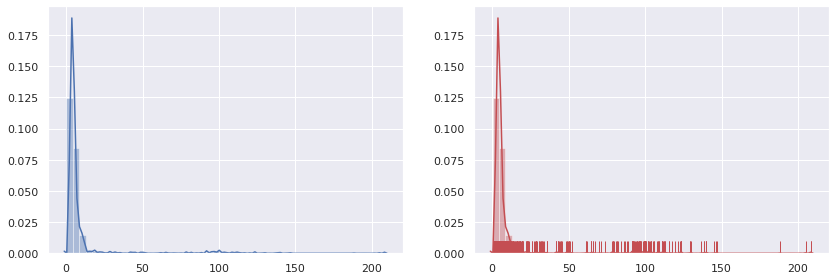

In [25]:
save_fname = os.path.join(save_dir, 'distances.png' )
plot_distances(dist0, dist1, save_fname)

In [26]:
#Export data to plot
X, X_, y = data.prepare_training_data(FeatureType.Divided, normalise=False,
                                                  cilyndrical=False)
X_train, X_test, X_train_, X_test_, y_train, y_test = train_test_split(X, X_, y,
                                                                       test_size=1-0.8, random_state=42)

y_pred = pd.DataFrame(y_predicted_orig)
y_true = pd.DataFrame(y_test_orig)


y_true.to_csv(os.path.join(save_dir, 'y_true.csv'), header=False, index=False)
y_pred.to_csv(os.path.join(save_dir, 'y_pred.csv'), header=False, index=False)
X_test.to_csv(os.path.join(save_dir, 'x_test.csv'), header=False, index=False)
print('[Output] Results saved at %', save_dir)

[Data] shape datas X:  (15192, 16)
[Data] shape data y:  (15192, 3)
[Data] len data total: 15192
[Output] Results saved at % results


## Plot Predicted Data ##


In [57]:
!pip install plotly.express

  Using cached https://files.pythonhosted.org/packages/d4/d6/8a2906f51e073a4be80cab35cfa10e7a34853e60f3ed5304ac470852a08d/plotly_express-0.4.1-py2.py3-none-any.whl


In [0]:
path1 = 'results/x_test.csv'
path2 = 'results/y_true.csv'
path3 = 'results/y_pred.csv'

x_test = pd.read_csv(path1, header=None)
y_test = pd.read_csv(path2, header=None)
y_pred = pd.read_csv(path3, header=None)

test = pd.concat([x_test, y_test], axis = 1, ignore_index = True)
pred = pd.concat([x_test, y_pred], axis = 1, ignore_index = True)
test.name = 'real'
pred.name = 'predict'

In [59]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plotly.__version__

'4.4.1'

In [67]:
from core.utils.utils import *

fig = track_plot_xyzz([test, pred], n_tracks = 40, 
               path='track.html', title='Track Prediction #5 Hit')

fig.show()
